<a href="https://colab.research.google.com/github/poojagolande256-ui/LLM_RAG_CHATBOT/blob/main/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gradio langchain langchain-google-genai langchain-cohere chromadb pypdf cohere

Build Rag Pipeline App

In [9]:
import gradio as gr
from langchain_google_genai import GoogleGenerativeAI
from langchain_cohere import CohereEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain import hub
from langchain_community.document_loaders import PyPDFLoader
import tempfile
import os
from google.colab import userdata

In [10]:
# Intialize gemini and cohere embeddings
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
os.environ["COHERE_API_KEY"] = userdata.get("COHERE_API_KEY")
llm = GoogleGenerativeAI(model = "gemini-2.5-flash", temperature = 0.3)
embddings = CohereEmbeddings(model="embed-english-v3.0")

In [11]:
# Initilize qa chain
qa_chain = None

# Process the pdf -> load the pdf, divide pdf into chunks, save in vector database
def process_pdf(pdf_file):
  global qa_chain
  # Load the document
  tmp_path = pdf_file.name if hasattr(pdf_file, "name") else pdf_file
  loader = PyPDFLoader(tmp_path)
  documents = loader.load()
  # Convert the document in Chunks
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
  chunks = text_splitter.split_documents(documents)
  # Save the chunks in vectordatabase
  vectorstore = Chroma.from_documents(chunks, embddings)
  # RAG pipeline with QA Chain
  prompt = hub.pull("rlm/rag-prompt")
  qa_chain = RetrievalQA.from_llm(
      llm,
      retriever = vectorstore.as_retriever(),
      prompt = prompt
  )
  return f"Processed {len(chunks)} chunks from pdf"

In [ ]:
def query_rag(question):
  if qa_chain is None:
    return "Upload PDF first"

  result = qa_chain.invoke({"query": question})
  answer = result["result"]
  return answer

# Build the interface using Gradio
with gr.Blocks() as demo:
  gr.Markdown("# RAG with Gemini and Cohere")
  # Add a pdf and upload button
  with gr.Row():
    pdf_input = gr.File(label = "Upload PDF", file_types=[".pdf"])
    upload_btn = gr.Button("Process PDF")
  # Add a status to show how many chunks loaded
  status = gr.Textbox(label="Status", interactive=False)
  # Ask question from user
  question = gr.Textbox(label="Ask any question about the document")
  answer = gr.Textbox(label="Chatbot answer", lines=10)
  submit_button = gr.Button("Submit Answer")
  # Add functionality to buttons
  upload_btn.click(process_pdf, inputs = pdf_input, outputs = status)
  submit_button.click(query_rag, inputs = question, outputs = answer)

# Launch the demo
demo.launch(debug=True, share=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://53e833eae932adc43f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Output

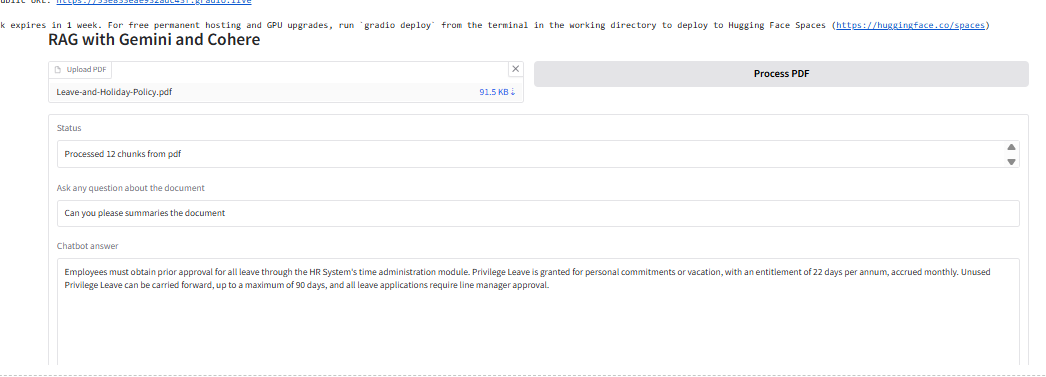